In [87]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale, resize, radon, iradon

import scipy
from scipy.ndimage.filters import gaussian_filter, median_filter
from scipy.signal import argrelextrema, find_peaks, cwt, ricker, morlet, gausspulse
from scipy.optimize import root, leastsq

import sys
from utils import * #add_noise, snr_calc, DC_and_SYM, fit
import h5py

from tomopy.prep.stripe import remove_stripe_fw

In [84]:
#h_sino = h5py.File('./sinograms/tomo_00001/tomo_00001.h5', 'r')
h_sino = h5py.File('./sinograms/tomo_00064_to_00067/tomo_00066.h5', 'r')

def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))


h_sino.visititems(print_attrs)
data = h_sino['/exchange/data'][()]
data_axes = h_sino['/exchange/data'].attrs['axes']
print(data_axes,' = ',data.shape)
theta = h_sino['/exchange/theta'][()]
print(max(theta))

exchange
exchange/data
    units: b'counts'
    axes: b'theta:y:x'
    description: b'transmission'
exchange/data_dark
    units: b'counts'
    axes: b'theta_dark:y:x'
exchange/data_white
    units: b'counts'
    axes: b'theta_white:y:x'
exchange/theta
    units: b'degrees'
exchange/title
implements
measurement
measurement/instrument
measurement/instrument/acquisition
measurement/instrument/acquisition/comment
measurement/instrument/acquisition/mode
measurement/instrument/detector
measurement/instrument/detector/x_actual_pixel_size
    units: b'microns'
measurement/instrument/detector/y_actual_pixel_size
    units: b'microns'
measurement/instrument/monochromator
measurement/instrument/monochromator/energy
    units: b'keV'
measurement/instrument/source
measurement/instrument/source/beamline
measurement/instrument/source/current
    units: b'mA'
measurement/instrument/source/datetime
measurement/instrument/source/mode
measurement/instrument/source/name
measurement/sample
measurement/sam

In [85]:
## For simulated data clip pixel values to >0 for realistic noise
#clip = 10000
#sinogram = np.clip(np.load('sinogram_off_center.npy'),clip, None)

## Define exposure
# for single sinogram, exposure is 1:1 noise to signal
# for summed sinograms exposure is 1:Y noise to signal where y is the dimension of y axis
#exposure = None
exposure = None#*data.shape[1]

## Preform stripe removal
#sinogram = remove_stripe_fw(data)

## Choose to sum along Y axis or to select a slice
#added = np.sum(data ,axis = 1)            #sum along Y axis
#sinogram = np.transpose(added)
sinogram_slice, sinogram_slice_snr = add_noise(np.transpose(data[:,100,:]), exposure)
sinogram = np.transpose(data[:,175,:])  #select a slice

## Add noise
sinogram_n, sinogram_noise_snr = add_noise(sinogram, exposure)


## Sum along theta
rowsum = np.sum(sinogram, axis=1)
rowsum_n = np.sum(sinogram_n, axis=1)

## find min via corss corr

#print(cross_correlate(rowsum))

/raid/home/everett/rotationcenter/utils.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  snr = np.mean(array)/np.std(noise-array)


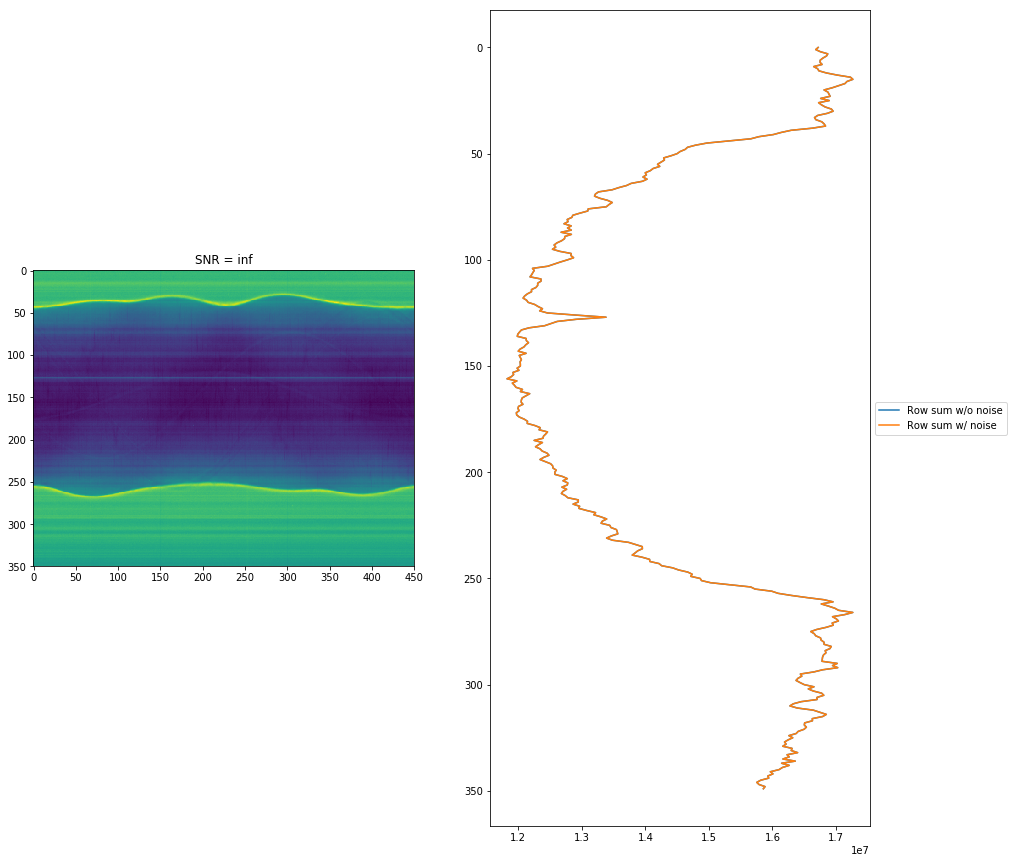

Mean =  148.2738004738083


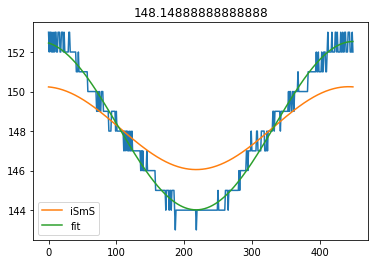

/raid/home/everett/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


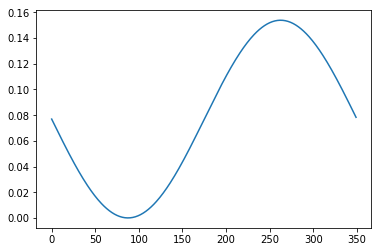

In [111]:
## Plot ##
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(sinogram)
#plt.subplot(132)
#plt.imshow(sinogram_n)
plt.title('SNR = ' + str(sinogram_noise_snr)[0:4])
plt.subplot(122)
plt.plot(rowsum, np.arange(0,sinogram.shape[0],1), label = 'Row sum w/o noise')
plt.plot(rowsum_n, np.arange(0,sinogram.shape[0],1), label = 'Row sum w/ noise')
plt.gca().invert_yaxis()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
'''
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(gaussian_filter(sinogram_slice, sigma=5))
plt.title('SNR = ' + str(sinogram_slice_snr)[0:4])
plt.subplot(122)
plt.plot(np.sum(gaussian_filter(sinogram_slice, sigma=10), axis = 1), np.arange(0,sinogram.shape[0],1))
plt.gca().invert_yaxis()
plt.show()
'''
SYM_min = []
for i in range(sinogram.shape[1]):
    test_rowsum = (sinogram_n[:,i] - np.min(sinogram_n[:,i]))/np.max(sinogram_n[:,i] - np.min(sinogram_n[:,i]))#rowsum_n[0:350]-np.min(rowsum_n)
    DC, SYM = np.zeros(len(test_rowsum), dtype = 'complex'), np.zeros(len(test_rowsum), dtype = 'complex')
    array_fft = np.fft.fft(test_rowsum)
    SYM[1] = array_fft[1]
    ifftr = np.fft.ifft(SYM)
    ifftr_even = np.fft.ifft(np.real(SYM))
    ifftr_odd = np.fft.ifft(np.imag(SYM)*1j)
    #print(argrelextrema(ifftr, np.less)[0][0])
    SYM_min.append(argrelextrema(ifftr, np.less)[0][0])

    '''
    plt.plot((test_rowsum-np.min(test_rowsum))/np.max(test_rowsum-np.min(test_rowsum))**.5)
    plt.plot((ifftr-np.min(ifftr))/np.abs(np.max(ifftr-np.min(ifftr)))**.5)
    plt.plot((ifftr_even-np.min(ifftr_even))/np.abs(np.max(ifftr_even-np.min(ifftr_even)))**.5, label = 'even')
    plt.plot((ifftr_odd-np.min(ifftr_odd))/np.abs(np.max(ifftr_odd-np.min(ifftr_odd)))**.5, label = 'odd')
    plt.title(str(argrelextrema(ifftr, np.less)[0]) + '  ' + str(np.max(ifftr_odd)))
    #plt.plot((np.arange(215)-150)**4/400000000)
    plt.legend()
    plt.show()
    '''

def fit_to_cos(array):
    N = len(array)
    data = array
    t = np.linspace(0, 4*np.pi, N)
    guess_mean = np.mean(data)
    guess_std = 3*np.std(data)/(2**0.5)/(2**0.5)
    guess_phase = 0
    guess_freq = .5
    guess_amp = np.max(data)-np.abs(np.min(data))

    # we'll use this to plot our first estimate. This might already be good enough for you
    data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data
    est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
    
    # recreate the fitted curve using the optimized parameters
    data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
    print('Mean = ', est_mean)
    return data_fit, data_first_guess
data_fit, data_first_guess = fit_to_cos(SYM_min)
SYM_min_SYM = np.zeros(len(SYM_min), dtype = 'complex')
SYM_min_SYM[1] = np.fft.fft(SYM_min)[1]
iSmS = np.fft.ifft(SYM_min_SYM)

plt.plot(np.asarray(SYM_min))
plt.plot(np.real(iSmS)+np.mean(data_fit), label = 'iSmS')
#plt.plot(data_first_guess, label = 'guess')
plt.plot(data_fit, label= 'fit')
plt.legend()
plt.title(np.mean(SYM_min))
plt.show()

plt.plot(ifftr_odd-np.min(ifftr_odd))
plt.show()

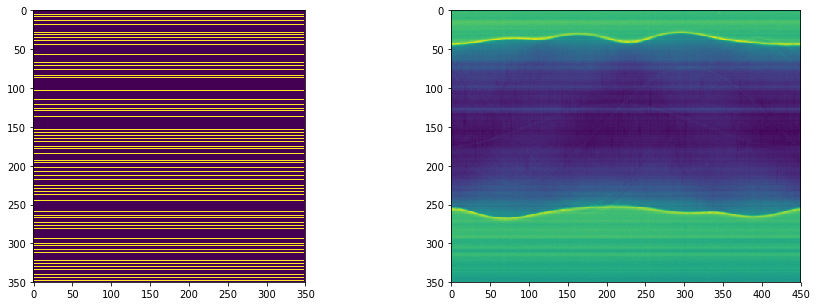

In [137]:
from skimage import feature
sumrow = np.zeros((len(rowsum),350))
for i in range(350):
    sumrow[:,i]=rowsum
cs = feature.canny(sumrow, sigma = 1)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(cs)
plt.subplot(122)
plt.imshow(sinogram)
plt.show()

# Shift the Detector

/raid/home/everett/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


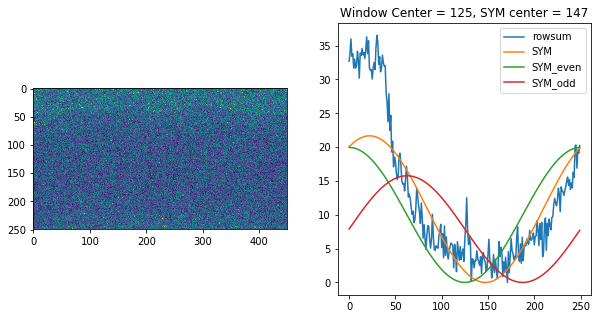

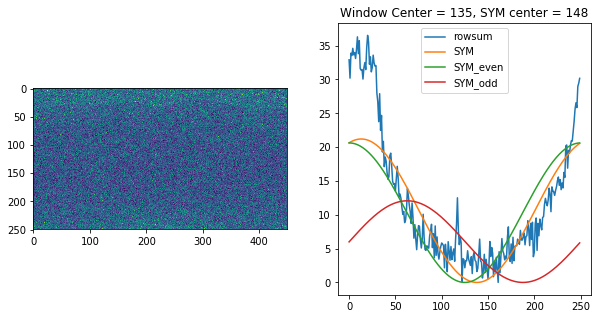

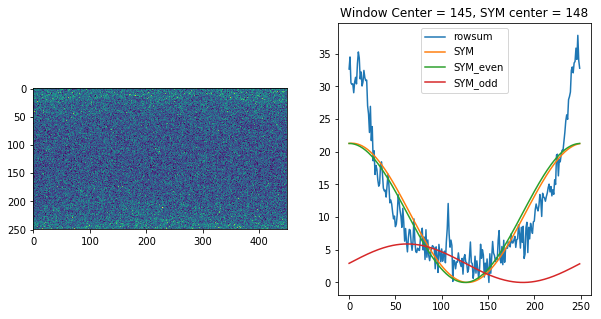

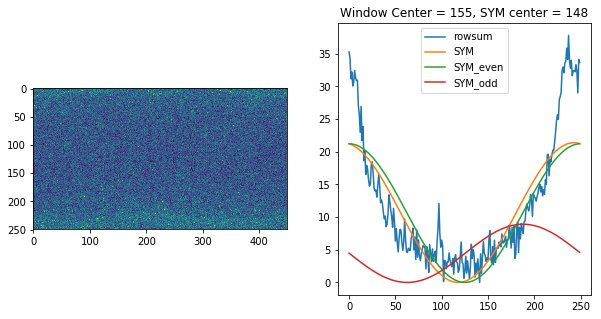

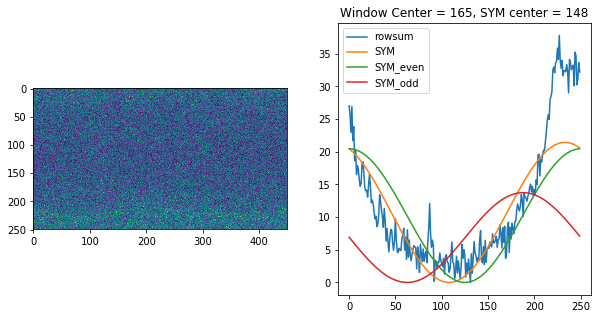

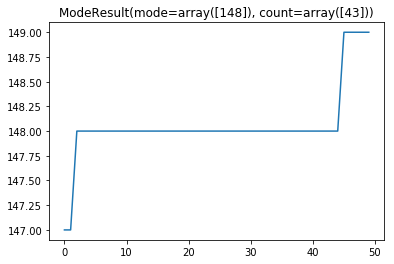

In [48]:
## Define scan area and range
scan_area = 250#int(sinogram.shape[0]/5)
shifting_range = sinogram.shape[0]-scan_area

## Add noise
sinogram_noise = add_noise(sinogram, exposure)[0]
## Shift scan_area through sinogram and extract the DC and SYM frequencies for each shift
DC_all, SYM_all = shift(sinogram_noise, scan_area, plot=10, shifting_range = 50)

# Plot DC, SYM and their even and odd Components

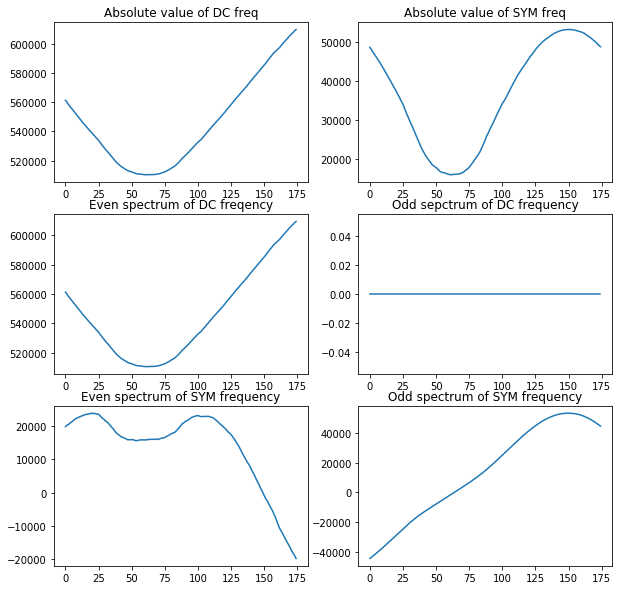

In [6]:
plot_DC_and_SYM(DC_all, SYM_all)


# Fit SYM_odd to polynomial and find root

Minimum of Dataset =  [151.5]
Polynomial Root =  [151.25140885]


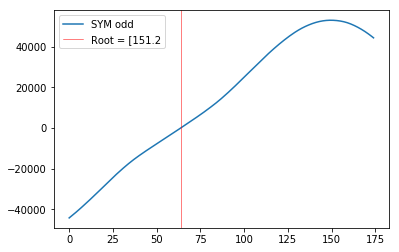

In [7]:
N = len(np.imag(SYM_all))
root_poly = SYM_odd_root_poly(np.imag(SYM_all), scan_area, 15)[0]
#rowsum_poly = SYM_odd_root_poly(rowsum_n[100:250], scan_area, 2)[1]
#data_min = SYM_odd_data_min(rowsum_poly(np.arange(sinogram.shape[0])), 0)
data_min = SYM_odd_data_min(np.imag(SYM_all), scan_area)


print('Minimum of Dataset = ', data_min)
print('Polynomial Root = ', root_poly)

plt.figure()
plt.plot(np.imag(SYM_all), label = 'SYM odd')
plt.axvline(root_poly[0]-scan_area/2, color='r', linewidth = '.5', label = 'Root = ' + str(root_poly)[0:6])
plt.legend()
plt.show()
#plt.plot(rowsum_poly(np.arange(sinogram.shape[0])))
#plt.show()

/raid/home/everett/rotationcenter/utils.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  snr = np.mean(array)/np.std(noise-array)


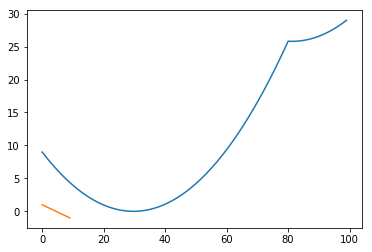

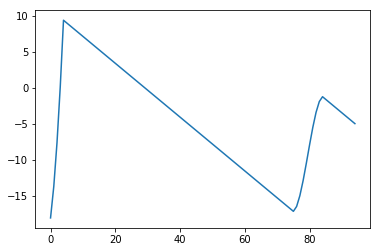

In [8]:
from scipy import signal
from skimage import restoration

start = 20
xrange = 100
exposure = None


#sq = np.zeros(10)
#sq[0:1]=8
#sq[1+1:100]=-8
#sq[50:55] = 8
#sq = -((np.arange(10)-50)*2)**2
#sq += np.abs(np.min(sq)*2)

window = 10
sq = -np.linspace(-1,1,window)
#sq= (np.linspace(-1,1,window))**2
c = ((np.linspace(0,10,100)-3))**2
c[80:100] += -np.linspace(0,20,20)
curve = add_noise(c, exposure)[0]
valconv = []

square_size = 0
'''
for i in range(xrange-square_size):
    #c = ((np.linspace(0,10,100)-i/10)*2)**2
    #curve = np.random.poisson(c*exposure /np.max(c))
    sq = np.zeros(100)
    #sq[i:i+square_size]=8
    #sq[i+1:100]=-8
    sq = (np.linspace(-1,1,100)-5+i/10)
    #sq = np.sin(np.linspace(0,2*np.pi,100)+np.pi*i/100)
    valconv.append(np.correlate(sq,curve))
'''
plt.plot(curve)
plt.plot(sq)
plt.show()

conv = np.correlate(curve, sq, mode = 'full')
plt.plot(conv[5:100])
plt.show()

109
True Min: = 30
[6.69834911]
[]


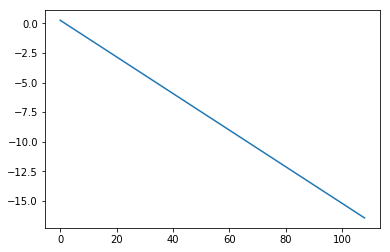

In [9]:
rt, fitted = SYM_odd_root_poly(conv[20:100], window,1)
print(len(conv))


argext = argrelextrema(conv, np.greater)[0]
argextmin = argrelextrema(fitted(np.arange(len(conv))), np.less)[0] - window/2
print('True Min: = 30')
print(rt)
print(argextmin)

plt.plot(fitted(np.arange(len(conv))))
plt.show()

/raid/home/everett/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


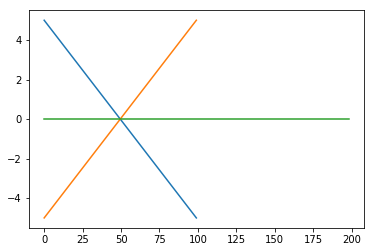

In [10]:
c = (np.linspace(0,10,100)-5)
fc = np.fft.fft(c)
dcsym = fc*-1j#np.zeros(100)*0j
#fc2 = #np.zeros(100)*0j

#for i in range(50):
#    dcsym[2*i+1] = fc[i]
#    fc2[2*i] = fc[i]
a = np.fft.ifft(dcsym)
b = np.fft.ifft(fc)
plt.plot(np.imag(a))
plt.plot(c)
plt.plot(np.correlate(b,a, mode='full'))
plt.show()

In [11]:
print(fitted())

TypeError: __call__() missing 1 required positional argument: 'val'

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
widths = np.arange(1, 5)
cwtmatr = signal.cwt(sig, signal.ricker, widths)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(cwtmatr, extent=[-1, 1, 5, 1], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.subplot(122)
#plt.plot(np.cos(2 * np.pi * 7 * t) )
#plt.plot(signal.gausspulse(t - 0.4, fc=2))
plt.plot(sig)

plt.show()

plt.plot(np.sum(cwtmatr, axis = 0))
plt.show()

In [ ]:
def MyCWT(data, wavelet, scales):

    output = np.zeros([len(scales), len(data)], dtype=complex)

    for ind, scale in enumerate(scales):

        window = scale*4*np.pi*10#Number of points to define correctly the wavelet
        waveletLength = min(window, len(data))#Number of points of the wavelet
        wavelet_data = wavelet(waveletLength, s=scale)#Need to precise w parameter???

        #To see the wavelets:
        '''
        plt.plot(wavelet_data)
        plt.xlabel('time (10^-3 sec)')
        plt.ylabel('amplitude')
        plt.title('Morlet Wavelet for scale='+str(scale)+'\nwidth='+str(window))
        plt.show()
        '''
        #Convolution to calculate the current line for the current scale:
        z = np.convolve(data, wavelet_data, mode='same')

        i = 0
        for complexVal in z:
            output[ind][i] = complex(complexVal.real, complexVal.imag)         
            i+=1

    return output

In [ ]:
widths = np.arange(150, 350, 1)
output =cwt(rowsum, ricker, widths)

In [ ]:

plt.figure(figsize=(20,20))
sub = np.real(output[250-150-1])/np.max(np.real(output[250-150-1]))
#for i in range(249-150-1):
    #sub -= np.real(output[i]/np.max(np.abs(np.real(output[i]))))
    #plt.plot(np.abs(np.real(output[int(i)])), label = str(i*6))
    
for i in range(len(output)):
    output[i] *= i+1

sum_output = np.sum(output, axis = 0)
    
plt.plot(sum_output/np.max(sum_output), label = 'output')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
print(np.trapz(sum_output/np.max(sum_output)))

In [154]:
sinogram.shape[]

(350, 450)